# MODIS Water Random Forest Hyperparameter Tuning

Version: 0.1.0

Date modified: 02.08.2022

Modified by: Caleb Spradlin

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path   
import optuna

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
FIGURE_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output'
RASTER_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output'
MODEL_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/models/'

TILE = 'global'
MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
colsToDrop = ['x_offset', 'y_offset']
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [3]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print('Imbalancing data, sampling {} from land'.format(frac))
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF or pandas Dataframe
- Drop unnecessary columns
- Clean data
- Split into Xs and Ys
- Train-test split

In [4]:
glob_string = '/att/nobackup/cssprad1/projects/modis_water/data/training_data/v1.1.0/MOD09_{}_*.parquet.gzip'.format(TILE)
data_paths = [fv for fv in glob.glob(glob_string)]
data_path = data_paths[0]
pprint(data_paths)

['/att/nobackup/cssprad1/projects/modis_water/data/training_data/v1.1.0/MOD09_global_WATER_TR_DATA_#5516128.parquet.gzip']


In [35]:
X_train, X_test, y_train, y_test = load_data(fpath=data_path,
                                             colsToDrop=colsToDrop,
                                             dataType=DATA_TYPE,
                                             cpu=True,
                                             splitXY=True,
                                             imbalance=False,
                                             land=True,
                                             frac=0.75,
                                             trainTestSplit=True,
                                             multi=False)

kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

In [6]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [7]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,4380548.0,458.441110,612.866072,-100.0,34.0,314.0,638.0,16000.0
sur_refl_b02_1,4380548.0,1461.109802,1458.120673,-100.0,2.0,1263.0,2651.0,16000.0
sur_refl_b03_1,4380548.0,312.811973,435.078485,-100.0,141.0,228.0,366.0,15361.0
sur_refl_b04_1,4380548.0,488.726512,518.725977,-100.0,140.0,432.0,661.0,16000.0
sur_refl_b05_1,4380548.0,1588.830738,1532.109456,-100.0,22.0,1402.0,2987.0,16000.0
sur_refl_b06_1,4380548.0,1202.874426,1150.821678,-100.0,94.0,1044.0,2091.0,16000.0
sur_refl_b07_1,4380548.0,661.322790,780.444156,-100.0,50.0,429.0,985.0,14952.0
ndvi,4380548.0,553.435426,8223.917760,-32762.0,-5294.0,2675.0,6712.0,32762.0
ndwi1,4380548.0,-2720.213393,6746.769559,-32759.0,-9166.0,-538.0,2040.0,32767.0
ndwi2,4380548.0,-132.884723,8620.384109,-32759.0,-7349.0,2370.0,5865.0,32767.0


In [8]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [9]:
output_interesting_idx(X_train, 'ndvi', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
824723,1,-2,130,59,51,75,88,30000,-10547,-10465
1223594,16,-9,168,96,20,48,0,29822,-14615,10000
4748838,-2,4,157,116,-18,78,19,30000,-9024,-6521
1927239,-100,612,-100,-100,1754,2306,1963,13906,-5805,-5246
2796122,-28,17,84,34,22,388,337,24627,-9160,-9039
...,...,...,...,...,...,...,...,...,...,...
1336723,8,-5,153,81,5,129,66,22203,-10806,-11639
5435538,2,-6,174,87,-23,115,65,20000,-11100,-12033
1514375,-41,145,-95,78,368,1094,926,17884,-7659,-7292
3817893,-21,12,24,20,5,20,11,28870,-2500,434


In [10]:
output_interesting_idx(X_train, 'ndwi1', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
1422167,-28,-44,163,120,-14,71,57,2222,22944,-12156
5219220,-100,-100,20,-100,-100,184,129,0,31727,-13429
3449538,1,-16,263,80,-16,27,17,11333,26446,-2320
3125701,-100,-16,-100,-100,-19,25,41,-7241,19981,-22800
3286672,-40,-44,100,60,17,21,24,476,28260,-31536
...,...,...,...,...,...,...,...,...,...,...
5425627,-72,-40,147,129,-20,64,85,-2857,22203,-27777
972260,-44,-6,67,-61,29,3,15,-7600,30000,-23333
2980239,-28,-36,201,39,-17,58,39,1250,22809,12144
3410824,-57,-64,195,19,-28,114,46,578,29936,-4425


In [11]:
output_interesting_idx(X_train, 'ndwi2', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
2055115,17,-2,190,86,-21,73,3,-12666,-10563,15536
1254827,87,126,126,174,132,81,-1,1830,2173,10160
1543760,128,-100,613,530,-100,335,185,-15892,-18510,32007
217364,657,1057,469,793,535,128,-1,2333,7839,10018
1810631,-77,-71,39,-20,-57,48,32,-405,-13797,26410
...,...,...,...,...,...,...,...,...,...,...
4785722,-36,-47,122,31,-44,62,41,1325,-7130,15594
2185930,67,-21,21,26,-34,40,11,-19130,-32105,32000
2145221,77,-9,188,124,-17,78,7,-12647,-12608,14464
4418748,142,204,268,219,152,69,-5,1791,4945,10502


# Model definition and training

Set TREES_ONLY to True if you only want to tune number of estimators, else max_depth, max_samples_split, min_samples_leaf will be tuned as well.

In [36]:
TREES_ONLY = True

In [37]:
def objective(trial):
    list_trees = [75, 100, 125, 150, 175, 200, 250, 300, 400, 500]
    max_depth = [80, 90, 100, 110]
    min_samples_leaf = [1, 2, 3, 4, 5]
    min_samples_split = [2, 4, 8, 10]
    bootstrap = [True, False]
    
    if TREES_ONLY:
        param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
                   'criterion':'gini', 
                   'max_depth':None, 
                   'min_samples_split':2, 
                   'min_samples_leaf':1, 
                   'min_weight_fraction_leaf':0.0, 
                   'max_features':'auto', 
                   'max_leaf_nodes':None, 
                   'min_impurity_decrease':0.0, 
                   'bootstrap':True, 
                   'oob_score':False, 
                   'n_jobs':-1, 
                   'random_state':42, 
                   'verbose':0, 
                   'warm_start':True, 
                   'class_weight':None, 
                   'ccp_alpha':0.0, 
                   'max_samples':None
                      }
    else:
        param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
                       'max_depth':trial.suggest_categorical('max_depth', max_depth), 
                       'min_samples_split':trial.suggest_categorical('min_samples_split', min_samples_split), 
                       'min_samples_leaf':trial.suggest_categorical('min_samples_leaf', min_samples_leaf), 
                       'bootstrap': True,
                       'criterion':'gini', 
                       'min_weight_fraction_leaf':0.0, 
                       'max_features':'auto', 
                       'max_leaf_nodes':None, 
                       'min_impurity_decrease':0.0, 
                       'oob_score':False, 
                       'n_jobs':-1, 
                       'random_state':42, 
                       'verbose':0, 
                       'warm_start':False, 
                       'class_weight':None, 
                       'ccp_alpha':0.0, 
                       'max_samples':None
                      }
    
    rf = skRF(**param)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    fp = cm[1][0]
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    del rf, preds, cm
    return precision, f1, fp

metric = {'precision': 0, 'f1': 1, 'false_positive': 2}

### Start hyperparameter tuning trials.

Ex output: Trial 0 finished with values: [0.9527224325581133, 0.9667626330841518, 9684.0] and parameters:

The metrics in order are: [precision, f1, false positives]

In [38]:
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(study_name='rf_tuning', directions=['maximize','maximize','minimize'])
study.optimize(objective, n_trials=25, timeout=20*60)

[I 2022-02-08 21:40:27,737] A new study created in memory with name: rf_tuning
[I 2022-02-08 21:44:18,332] Trial 0 finished with values: [0.9527114632252618, 0.9666297319957821, 9812.0] and parameters: {'n_estimators': 300}. 
[I 2022-02-08 21:47:04,443] Trial 1 finished with values: [0.9527696935882743, 0.9665918654381035, 9884.0] and parameters: {'n_estimators': 200}. 
[I 2022-02-08 21:49:22,993] Trial 2 finished with values: [0.9526557194167329, 0.9666000969387804, 9813.0] and parameters: {'n_estimators': 175}. 
[I 2022-02-08 21:54:18,048] Trial 3 finished with values: [0.9527163906838607, 0.9666463990577474, 9797.0] and parameters: {'n_estimators': 400}. 
[I 2022-02-08 21:56:09,345] Trial 4 finished with values: [0.9526757346539579, 0.9666132256482471, 9810.0] and parameters: {'n_estimators': 125}. 
[I 2022-02-08 21:57:52,686] Trial 5 finished with values: [0.9526757346539579, 0.9666132256482471, 9810.0] and parameters: {'n_estimators': 125}. 
[I 2022-02-08 22:02:53,225] Trial 6 fin

## Get metrics from the overall hyperparameter tuning

In [39]:
METRIC_TO_USE = 'false_positive'# out of 'precision', 'f1', 'false_positive'

In [40]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Using {} idx: {}".format(METRIC_TO_USE, metric[METRIC_TO_USE]))
trials = study.best_trials
if METRIC_TO_USE == 'false_positive' or METRIC_TO_USE == 'false_negative':
    trial_score = min([trial.values[metric[METRIC_TO_USE]] for trial in trials])
else:
    trial_score = max([trial.values[metric[METRIC_TO_USE]] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[metric[METRIC_TO_USE]] == trial_score][0]
best_trial = [trial for trial in trials if trial.values[metric[METRIC_TO_USE]] == trial_score][0]
print(best_trial_params)
print(trial_score)

trial_scores = [trial.values for trial in trials]
trial_params = [trial.params for trial in trials]

for score, param in zip(trial_scores, trial_params):
    print(score)
    for k, v in param.items():
        print("     {}: {}".format(k, v))

study_df = study.trials_dataframe()
study_df.to_csv("hyperopt_tuning_trial_{}_random_forest.csv".format(
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')))

Number of finished trials: 7
Using false_positive idx: 2
{'n_estimators': 400}
9797.0
[0.9527696935882743, 0.9665918654381035, 9884.0]
     n_estimators: 200
[0.9527163906838607, 0.9666463990577474, 9797.0]
     n_estimators: 400
[0.9527163906838607, 0.9666463990577474, 9797.0]
     n_estimators: 400


### Visualize the optimization history

<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

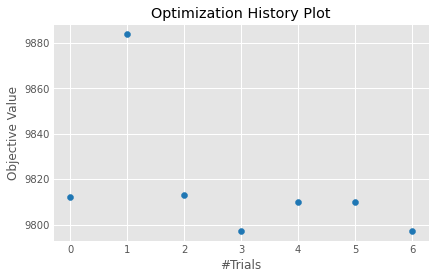

In [41]:
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[metric[METRIC_TO_USE]])

### Visualize hyperparameter importances

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

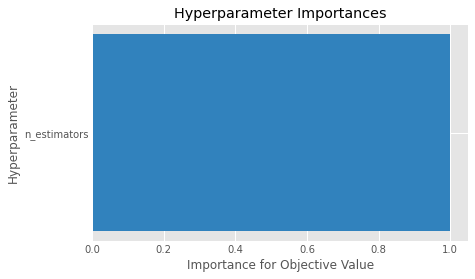

In [42]:
optuna.visualization.matplotlib.plot_param_importances(study, target=lambda t: t.values[metric[METRIC_TO_USE]])

### Visualize the loss functions compares to number of estimators during tuning

In [43]:
udf = study_df.drop_duplicates(['params_n_estimators']).sort_values(by='params_n_estimators')
udf_by_score = udf[udf.values_0 == udf.values_0.max()]
udf

,number,values_0,values_1,values_2,datetime_start,datetime_complete,duration,params_n_estimators,system_attrs_nsga2:generation,state
4,4,0.952676,0.966613,9810.0,2022-02-08 21:54:18.051536,2022-02-08 21:56:09.345675,0 days 00:01:51.294139,125,0,COMPLETE
2,2,0.952656,0.966600,9813.0,2022-02-08 21:47:04.446160,2022-02-08 21:49:22.993382,0 days 00:02:18.547222,175,0,COMPLETE
1,1,0.952770,0.966592,9884.0,2022-02-08 21:44:18.335220,2022-02-08 21:47:04.443016,0 days 00:02:46.107796,200,0,COMPLETE
0,0,0.952711,0.966630,9812.0,2022-02-08 21:40:27.743239,2022-02-08 21:44:18.332259,0 days 00:03:50.589020,300,0,COMPLETE
3,3,0.952716,0.966646,9797.0,2022-02-08 21:49:22.996496,2022-02-08 21:54:18.048749,0 days 00:04:55.052253,400,0,COMPLETE


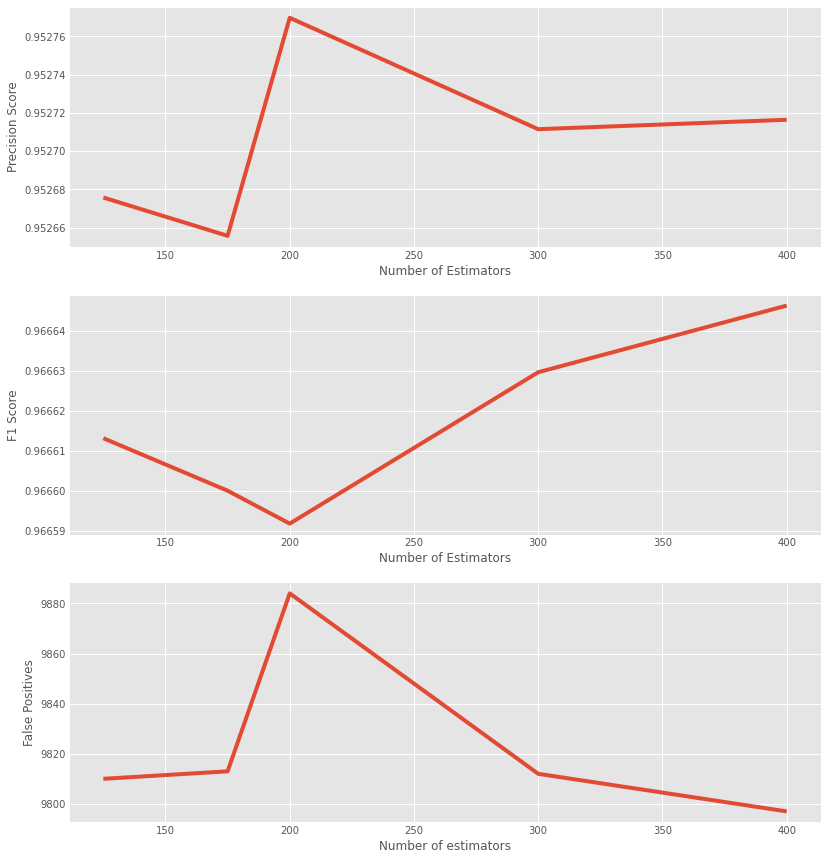

In [44]:
if TREES_ONLY:
    udf = study_df.drop_duplicates(['params_n_estimators']).sort_values(by='params_n_estimators')
    udf_by_score = udf[udf.values_0 == udf.values_0.max()]
    fig, ax = plt.subplots(3, figsize=(12,15))
    ax[0].plot(udf['params_n_estimators'], udf['values_0'], label='Precision per n estimators')
    ax[0].set_xlabel('Number of Estimators')
    ax[0].set_ylabel('Precision Score')
    ax[1].plot(udf['params_n_estimators'], udf['values_1'], label='F1 score per n estimators')
    ax[1].set_xlabel('Number of Estimators')
    ax[1].set_ylabel('F1 Score')
    ax[2].plot(udf['params_n_estimators'], udf['values_2'], label='False positives per n estimators')
    ax[2].set_xlabel('Number of estimators')
    ax[2].set_ylabel('False Positives')

## Training the model with the best hyperparamers

In [45]:
hyperparameters = best_trial_params
hyperparameters['n_jobs'] = -1
hyperparameters['warm_start'] = True
print('Using these params:')
pprint(hyperparameters)
classifier = skRF(**hyperparameters)

Using these params:
{'n_estimators': 400, 'n_jobs': -1, 'warm_start': True}


In [46]:
bestModel = None
bestModelScore = 0
scores = []
for trainIdx, testIdx in kf.split(X_train):
    print("Train {}, Test {}".format(trainIdx, testIdx))
    X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
    y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
    print('Fitting model')
    classifier.fit(X_train_valid, y_train_valid)
    print('Getting score')
    score = classifier.score(X_test_valid, y_test_valid)
    if score>=bestModelScore:
        bestModelScore = score
        print('Training accuracy score: {}'.format(score))
        bestModel = classifier
    print('Predicting for test set')
    test_predictions = classifier.predict(X_test_valid)
    print(classification_report(y_test_valid, test_predictions))
    print('Score: {}'.format(score))
    scores.append(score)
    del test_predictions, score

Train [ 876110  876111  876112 ... 4380545 4380546 4380547], Test [     0      1      2 ... 876107 876108 876109]
Fitting model
Getting score
Training accuracy score: 0.9677449178756092
Predicting for test set
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    463694
           1       0.95      0.98      0.97    412416

    accuracy                           0.97    876110
   macro avg       0.97      0.97      0.97    876110
weighted avg       0.97      0.97      0.97    876110

Score: 0.9677449178756092
Train [      0       1       2 ... 4380545 4380546 4380547], Test [ 876110  876111  876112 ... 1752217 1752218 1752219]
Fitting model
Getting score
Training accuracy score: 0.9998812934448871
Predicting for test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    464040
           1       1.00      1.00      1.00    412070

    accuracy                           1.00    876110
   

## Model testing and training/testing data validation

### Get model metrics

In [47]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.967

In [48]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [49]:
predictionProbabilityList = list()
for i, subarr in enumerate(prediction_probs):
    predictionProbabilityList.append(subarr[1])
predictionProbabilityArray = np.asarray(predictionProbabilityList)

### Show the distribution of the probability of the predicted values.

These are the probability that each test data point is water p=1 vs land p=0. Usually a relatively flatter distribution on one of the sides shows us that the model is not as confident on predicting that side.

Text(0.5, 1.0, 'Distribution of the probability of predicted values')

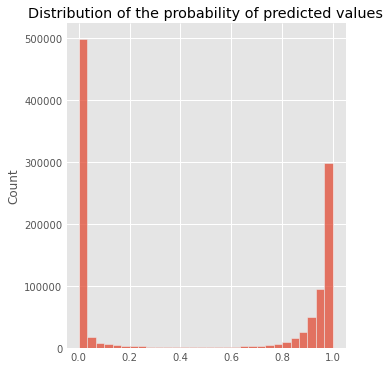

In [50]:
sns.displot(predictionProbabilityArray, bins=30)
plt.title('Distribution of the probability of predicted values')

In [51]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_test.astype(np.int16)

In [52]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    579782
           1       0.95      0.98      0.97    515355

    accuracy                           0.97   1095137
   macro avg       0.97      0.97      0.97   1095137
weighted avg       0.97      0.97      0.97   1095137

Test Recall
-------------------------------------------------------
0.9560231259335406
Confusion Matrix
-------------------------------------------------------
[[554285  25497]
 [ 10144 505211]]


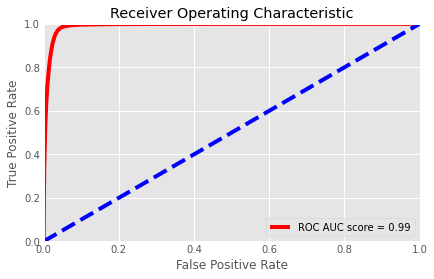

In [53]:
clf = classifier

probs = clf.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Permutaion importance

In [54]:
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=5,
                                                        random_state=42)

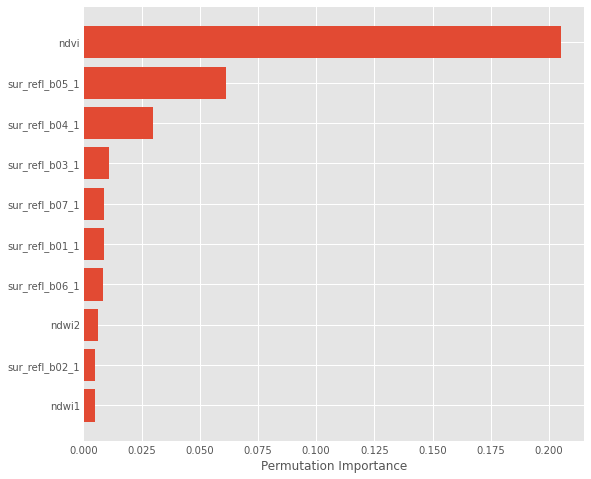

In [55]:
png_save_path = 'mw_{}_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    MODEL,
    hyperparameters['n_estimators'],
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig(png_save_path)

Garbage collection

In [56]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## Save the model for future use

In [58]:
model_save_path = 'mw_{}_{}_{}_{}_tuned_{}.sav'.format(TILE,
                                                              score,
                                                              hyperparameters['n_estimators'],
                                                              MODEL,
                                                              'cpu',
                                                              datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_sav_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: /att/nobackup/cssprad1/projects/modis_water/models/mw_global_0.967_400_rf_tuned_cpu.sav
RandomForestClassifier(n_estimators=400, n_jobs=-1, warm_start=True)


['mw_global_0.967_400_rf_tuned_cpu.sav']

# Testing: raster testing

In [59]:
TILE = 'h12v09'

In [60]:
DAY = 218
YEAR = 2006
PATH = '/att/nobackup/cssprad1/projects/modis_water/data/test_data/{}/'.format(TILE)

In [61]:
vars_list = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list.sort()
vars_list

['/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b01_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b02_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b03_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b04_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b05_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b06_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b07_1.tif']

## Get dimensions of inputs

In [62]:
vrt_opts = gdal.BuildVRTOptions(separate=True)
dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_opts)
nrows, ncols = dd.RasterYSize, dd.RasterXSize
dd = None
if os.path.exists('tmp.vrt'):
    os.remove('tmp.vrt') 
nrows, ncols

(4800, 4800)

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [63]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [64]:
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[6643 7273 6168 ...  452  962 3003]
 [6643 7273 6168 ...  452  962 3003]
 [6172 6885 5686 ...  546  881 2691]
 ...
 [ 419 2432  206 ... 7060 1580 5026]
 [ 751 2327  316 ... 5120 -404 2895]
 [ 751 2327  316 ... 5120 -404 2895]]
460.8 MB size


In [65]:
def predictRaster(img_chunk):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, dtype=np.int16)
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [66]:
predictedRaster, predictedProbaRaster, df = predictRaster(im)

Making predictions from raster


In [67]:
shp = (4800, 4800)
left = list()
right = list()
for i, subarr in enumerate(predictedProbaRaster):
    left.append(subarr[0])
    right.append(subarr[1])
leftArr = np.asarray(left)
rightArr = np.asarray(right)
probaLand = leftArr.reshape(shp)
probaWater = rightArr.reshape(shp)

## Raster as a DataFrame: description and histogram

In [68]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,23040000.0,406.319013,434.922643,-28672.0,250.0,306.0,360.0,9953.0
1,23040000.0,3162.238815,649.746304,-28672.0,2923.0,3309.0,3518.0,9242.0
2,23040000.0,291.899561,406.622174,-28672.0,166.0,212.0,269.0,9013.0
3,23040000.0,557.999866,406.551242,-28672.0,421.0,493.0,546.0,9716.0
4,23040000.0,3133.262860,632.134972,-28672.0,2923.0,3264.0,3468.0,9040.0
5,23040000.0,1720.846256,526.672817,-28672.0,1506.0,1710.0,1812.0,7103.0
6,23040000.0,530.845410,1843.350129,-28672.0,480.0,547.0,610.0,6316.0
7,23040000.0,7686.235761,2031.676702,-32222.0,7954.0,8349.0,8546.0,32203.0
8,23040000.0,2985.519139,1161.269606,-32727.0,2979.0,3300.0,3518.0,32620.0
9,23040000.0,6634.247958,1770.533043,-32727.0,6823.0,7209.0,7398.0,32679.0


Remember this is unfiltered data. Distributions will look strange due to lack of QA.

Text(0.5, 1.0, 'Distribution of each band and calculated idx')

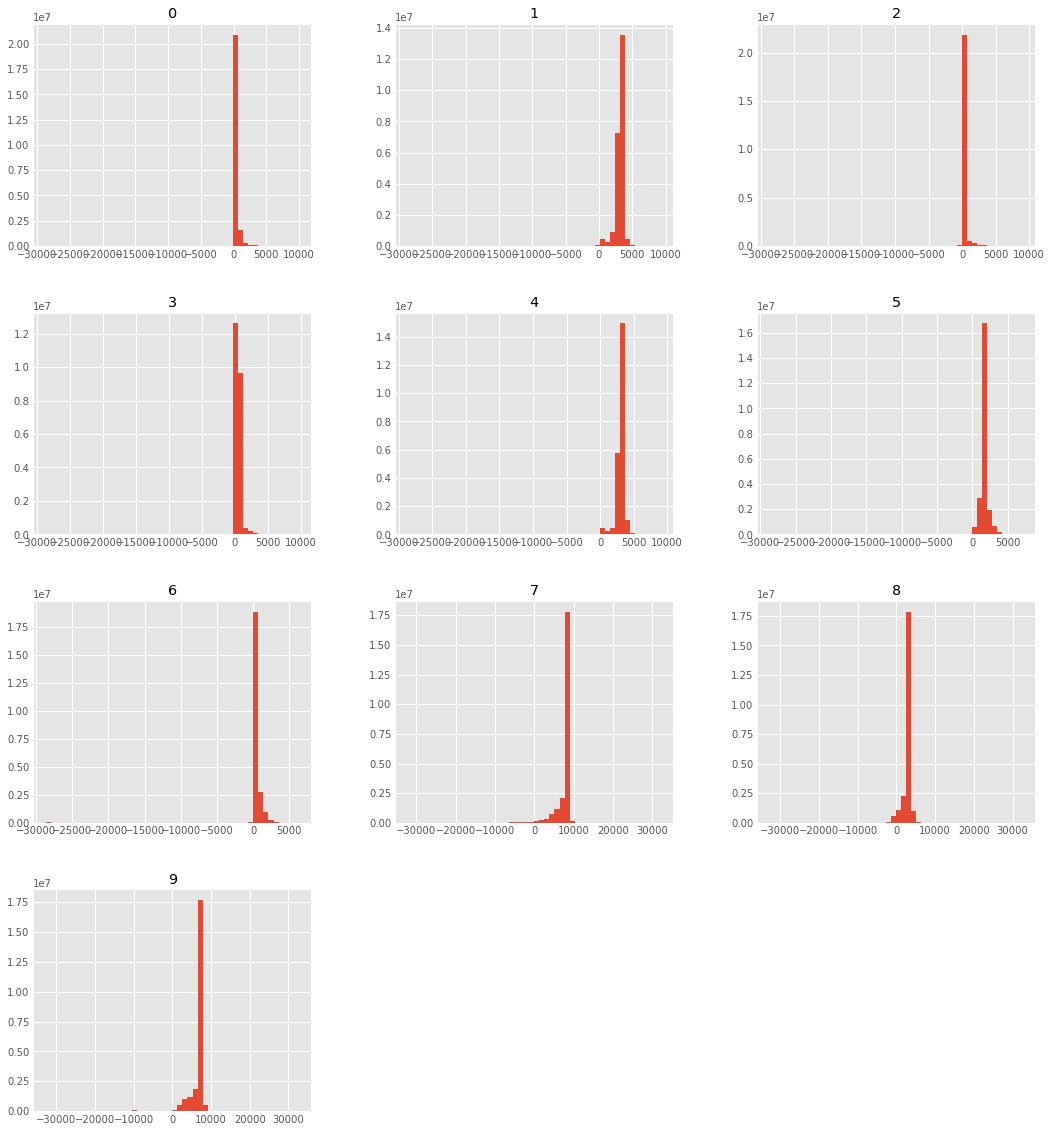

In [69]:
df.hist(figsize=(16, 20), bins=50)
plt.title('Distribution of each band and calculated idx')

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [70]:
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(4800, 4800)

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [71]:
qaMask = '/att/nobackup/cssprad1/projects/modis_water/data/qa_masks'
waterMask = '/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019'
qa_list = [fn for fn in glob.glob(os.path.join(qaMask, '*A{}{:03}.{}*bad_good_mask.tif'.format(YEAR, DAY, TILE)))]
water_list = [fn for fn in glob.glob(os.path.join(waterMask, '*{}*.tif'.format(TILE)))]
qa_mask = qa_list[0]
water_mask = water_list[0]
print(water_mask)
print(qa_mask)
ds = gdal.Open(qa_mask, gdal.GA_ReadOnly)
waterMask = gdal.Open(water_mask, gdal.GA_ReadOnly)
qaMaskMatrix = ds.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMaskMatrix = waterMask.GetRasterBand(1).ReadAsArray().astype(np.int16)
ds = None
waterMask = None

/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019/MOD44W_h12v09_min2000_2019.tif
/att/nobackup/cssprad1/projects/modis_water/data/qa_masks/MOD09GA.A2006218.h12v09.061.2020268185436_bad_good_mask.tif


In [72]:
waterMaskMatrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

### Mask out results if QA Mask says pixel is "bad"

In [73]:
maskedResult = np.where(qaMaskMatrix == 0, reshp, -9999)
maskedResultProba = np.where(qaMaskMatrix == 0, probaWater, -9999)
waterMasked = np.where(qaMaskMatrix == 0, waterMaskMatrix, -9999)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

# Generating stats for predicted and truth

## Predicted Raster

In [74]:
TILE = 'global_rf_{}'.format(TILE)

Text(0.5, 1.0, 'Predicted water mask')

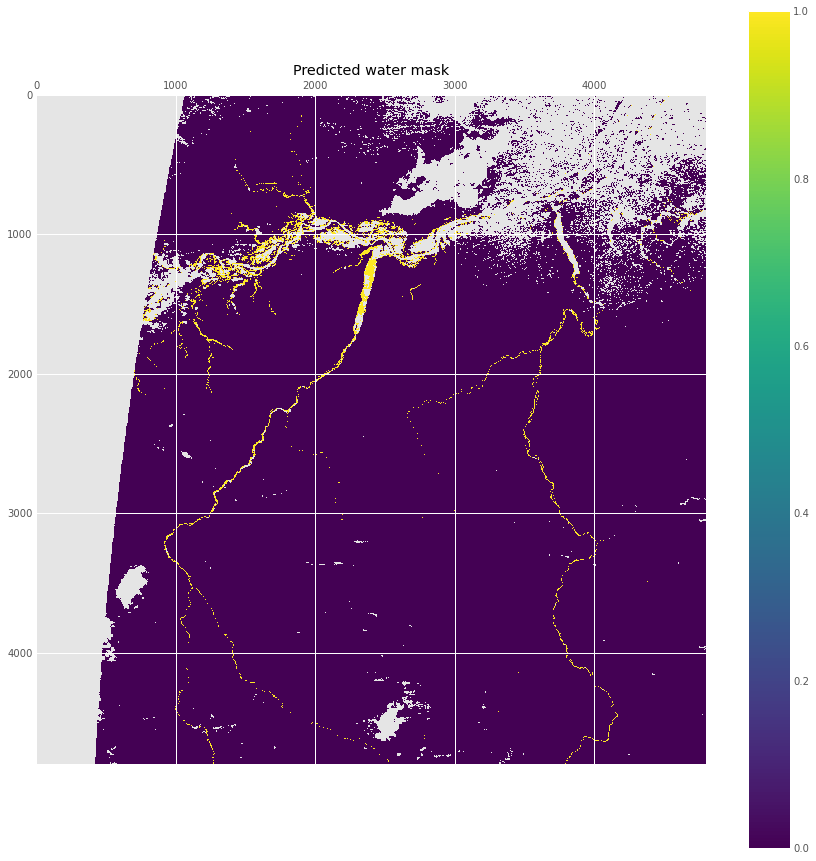

In [75]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResult), fignum=1)
plt.colorbar()
plt.title('Predicted water mask')

## Predicted Probabilities

Text(0.5, 1.0, 'Predicted probabilities of water')

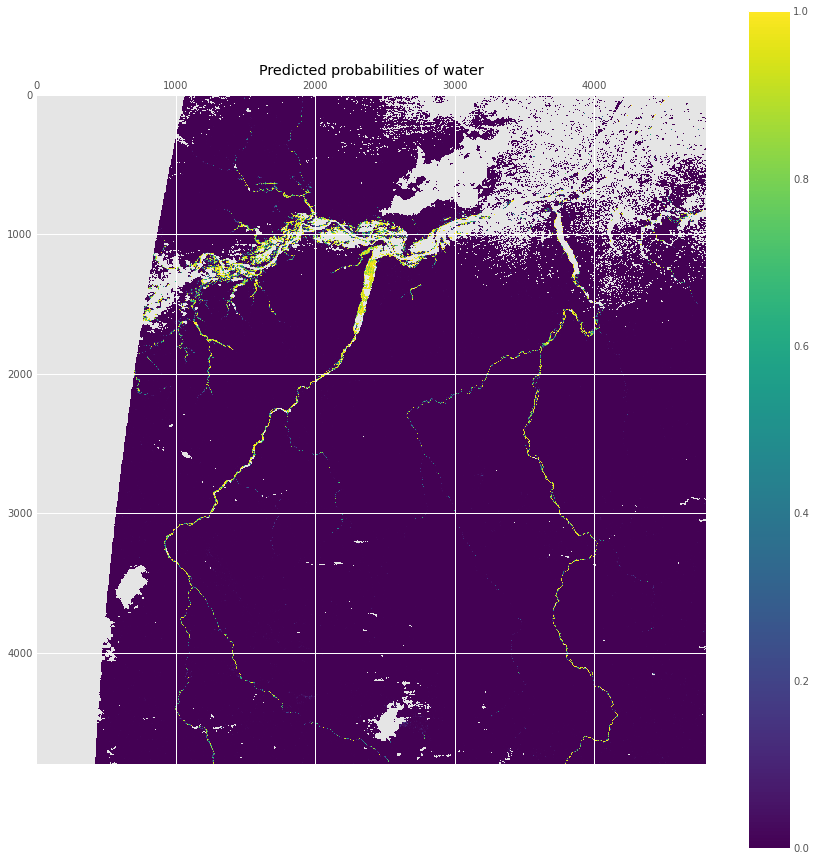

In [76]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResultProba), fignum=1)
plt.colorbar()
plt.title('Predicted probabilities of water')

## Minimum extent water mask

Text(0.5, 1.0, 'Minimum extent water mask')

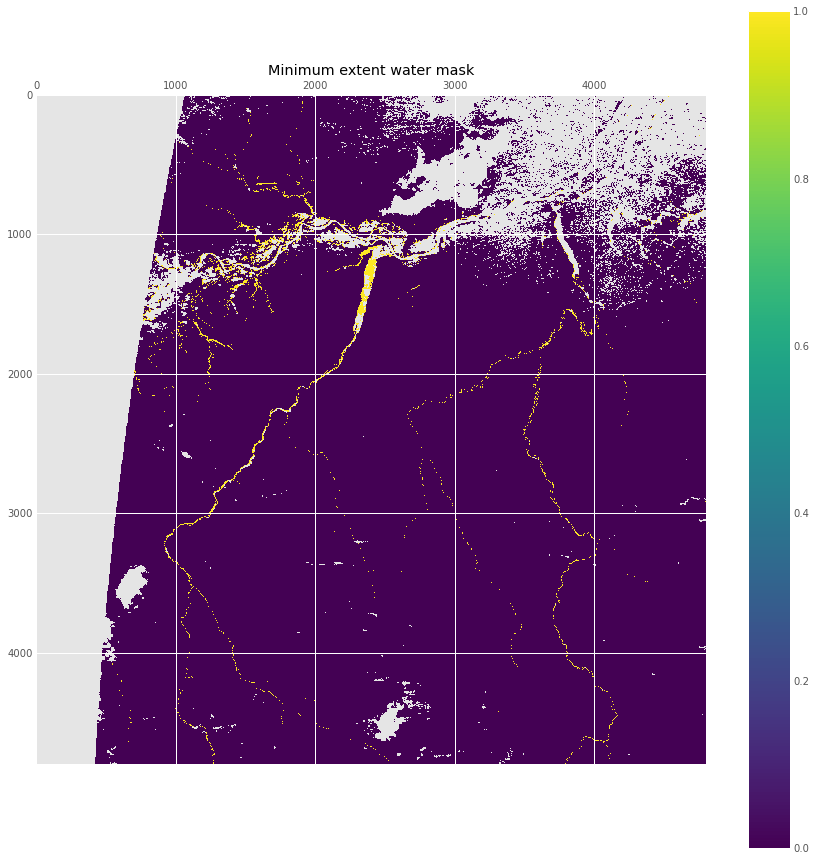

In [77]:
plt.figure(figsize=(15, 15))
truth = np.where(waterMasked==-9999, np.NaN, waterMasked)
truth = np.where(waterMasked==250, np.NaN, truth)
truthPlt = plt.matshow(truth, fignum=1)
plt.colorbar()
plt.title('Minimum extent water mask')

## Metrics on test raster

In [78]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))

### Count num of occurences for each class with the masked predicted result

In [79]:
countNoData = np.count_nonzero(maskedResult == -9999)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 Nodata occurences: 5364592
 Land occurance: 17418936
 Water occurances: 256472


### Count num of occurences for each class with the water mask

In [80]:
countNoDataT = np.count_nonzero(waterMasked == -9999)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Min. extent water mask vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

Min. extent water mask vals
 Nodata occurences: 5364592
 Land occurance: 17468360
 Water occurances: 207048


### Model metrics on raster data

In [81]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print("Jian's metric : {}".format(jians))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))

Metrics of Accuracy for Raster Test Data
True Positives:  159412
True Negatives:  17371300
False Positives: 97060
False Negatives: 47636
Total "good" data: 17675408
Accuracy*: 0.9918137108914261
Jian's metric : 0.009093298663511214
Precision: 0.6215571290433264
Recall: 0.769927746223098
f1: 0.687832240248533


## Output predicted raster to GeoTiff

In [82]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output probabilies raster masked by good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPathProba, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResultProba)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/2006_218_global_rf_h12v09_predicted_rf.tif
/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/waterMask_2006_qa_218.tif
/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/2006_218_global_rf_h12v09_predicted_probabilities_rf.tif
Transform
(-6671703.118, 231.656358, 0.0, 0.0, 0.0, -231.656358)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800
